## GLMAT: 2D kernel, ML estimation

In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import scipy as sp

import mat_neuron._model as mat
from dstrf import strf, mle

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# model parameters: (α1, α2, ω, τ1, τ2, tref)
matparams = np.asarray([100, 2, 7, 10, 200, 2], dtype='d')
model_dt = 0.5

# data parameters
duration = 400000
n_samples = int(duration / model_dt)
n_assim = 1
n_test = 0

['bbm', 'wb2', 'nbtf', 'nbs', 'bbf', 'nbts', 'off', 'bbs']


/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


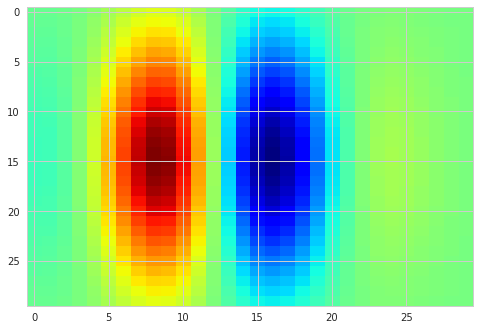

In [3]:
# STRF: keep this very simple for proof of principle
stim_dt = 10.0
nfreq = 30
ntau  = 30

from scipy.signal import resample
filts = np.load('../../filters.npz')
print(filts.keys())
k1 = resample(filts['bbs'], nfreq, axis=0)[:,:ntau] * 5

plt.imshow(k1, cmap='jet', aspect='auto')

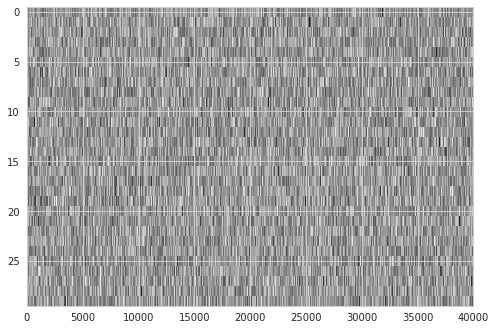

In [4]:
# generate some random data to fit
np.random.seed(1)
stim_dt = 10.0
upsample = int(stim_dt / model_dt)
stim = np.random.randn(nfreq, int(n_samples / (stim_dt / model_dt)))
stim[:,:100] = 0
plt.imshow(stim, aspect='auto')

In [5]:
# reduced data:
# nfreq = 4
# k1 = k1[15:15+nfreq]
# stim = stim[15:15+nfreq]

In [6]:
def filter_stimulus(S, kernel):
    """Convolve spectrogram S with spectrotemporal kernel. Kernel should not be flipped."""
    nf, nt = S.shape
    X = np.zeros(nt)
    for i in range(nf):
        X += np.convolve(S[i], kernel[i], mode="full")[:nt]
    return X

def predict_spikes(V, params, dt, upsample):
    a1, a2, omega, t1, t2, tref = params
    return mat.predict_poisson(V - omega, (a1, a2), (t1, t2), tref, 
                               dt, upsample)

In [7]:
data = []
V = filter_stimulus(stim, k1)
for i in range(n_assim + n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample)
    H = mat.adaptation(spikes, matparams[3:5], model_dt)
    z = np.nonzero(spikes)[0]
    d = {"H": H,
         "duration": duration,
         "spike_t": z, 
         "spike_v": spikes,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

1569

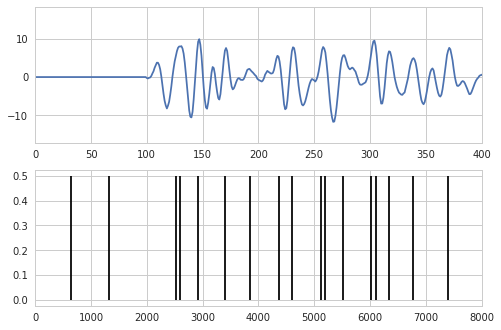

In [8]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(V)
for i, d in enumerate(data):
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.set_xlim(0, 8000 // upsample)
ax2.set_xlim(0, 8000)
len(data[0]["spike_t"])

## Estimate parameters

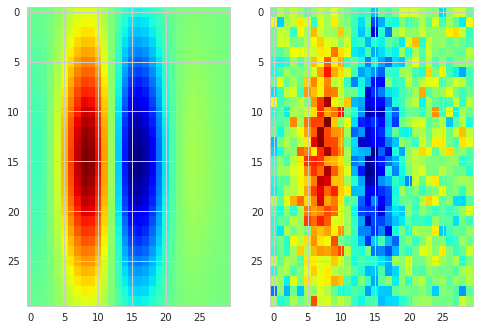

In [9]:
from theano import config
import scipy.optimize as op
ftype = config.floatX

# combine the trials
spikes = np.stack([d["spike_v"] for d in data], axis=1).astype(ftype)
# spikes in the exponential basis set
X_spikes = np.stack([d["H"] for d in data], axis=2).astype(ftype)
# generate design matrix for stimulus
X_stim = strf.lagged_matrix(stim, ntau).astype(ftype)
# initial guess of strf
sta = strf.correlate(X_stim, spikes)
plt.subplot(121).imshow(k1, cmap='jet', aspect='auto')
plt.subplot(122).imshow(np.fliplr(strf.as_matrix(sta, ntau)), cmap='jet', aspect='auto')
# plt.plot(np.fliplr(strf.as_matrix(sta, ntau)).T)
# plt.plot(k1.T)

array(6428.444805405093)

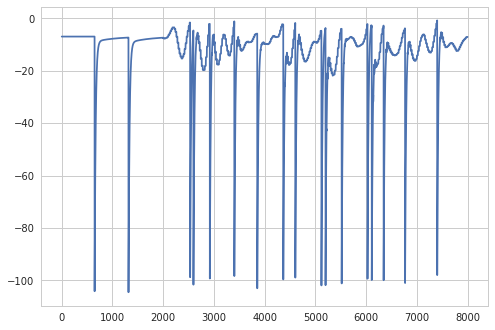

In [10]:
lfuns = mle.make_likelihood(X_stim, X_spikes, spikes, stim_dt, model_dt)
w = np.r_[matparams[2], matparams[:2], strf.as_vector(np.fliplr(k1))].astype(ftype)
lci = lfuns['lci'](w)
plt.plot(lci[:8000])
lfuns['loglike'](w)

In [11]:
%%time
w0 = np.r_[0, 0, 0, sta]
w1 = op.fmin_ncg(lfuns['loglike'], w, lfuns['gradient'], 
                 fhess_p=lfuns['hessianv'], maxiter=100)

Optimization terminated successfully.
         Current function value: 5981.067503
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 30
         Hessian evaluations: 123
CPU times: user 25 s, sys: 1.33 s, total: 26.3 s
Wall time: 26.4 s


[   7.48542459  108.68051843    2.26960079]


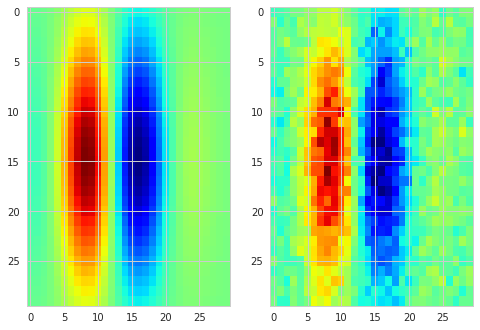

In [12]:
print(w1[:3])
rf_est = strf.as_matrix(w1[3:], ntau)
plt.subplot(121).imshow(k1, cmap='jet', aspect='auto')
plt.subplot(122).imshow(np.fliplr(rf_est), cmap='jet', aspect='auto')